# Imports

In [10]:
# utils
import os
import numpy as np
from os import listdir
from matplotlib.cm import *
from tensorflow.keras.utils import to_categorical
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from scipy import stats
from statistics import median

# sklearn imports
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, LeaveOneOut


import seaborn as sns

# our own customized Naive Bayes
import naive_bayes_custom

# image processing imports
from matplotlib.pyplot import imread
from PIL import Image
import cv2
from skimage.transform import resize
from scipy.signal import convolve2d as conv2, convolve
from PIL import Image, ImageFilter
from skimage.io import imread, imsave

# multiprocessing imports
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool

# Setup
plt.rcParams['figure.figsize'] = (20, 8)
AVAILABLE_CPU = multiprocessing.cpu_count()

In [29]:
# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2


def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img


def get_dataset(dataset_path='Dataset'):
    # Getting all data from data path:
    try:
        X = np.load('X.npy')
        Y = np.load('Y.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']  # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path + '/' + label
            for data in listdir(datas_path):
                img = get_img(datas_path + '/' + data)
                X.append(img)
                Y.append(i)
        # Create dateset:
        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    
    X_unf = np.copy(X)    
    X = np.array([X[i].flatten() for i in range(len(X))])
    Y_hot_vec = Y.copy()
    Y = np.where(Y==1)[1]
    permutation = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}
    for i in range(len(Y)):
        Y[i] = permutation[Y[i]]
        
    return X, X_unf, Y, Y_hot_vec


if __name__ == '__main__':
    X, X_unf, Y, Y_hot_vec = get_dataset()

In [3]:
# cleaning
subset = [0,1,2,3,4,5,6,7,8,9,10,53,54,55,56,57,58,59,60,61,62,63]
def cleaning(img, rows):
    for row in rows:
        img[row][0:10] = 1
        img[row][53:64] = 1
    return img

In [4]:
def clean_image(image, threshold = 0.5, new_size_tuple = (64,64)):
    new_img = []
    for el in image.flat: 
        if el > threshold: new_img.append(1)
        else: new_img.append(0)
        
    return np.array(new_img)

In [5]:
img = X[0]
    
new_img = clean_image(img)

8


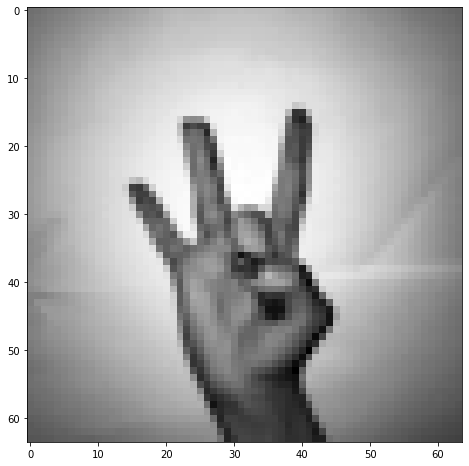

In [40]:
idx = 1200
print(Y[idx])
plt.imshow(X[idx].reshape(64, 64), cmap='gray', interpolation='nearest')

# Principal Component Analysis

## Normalization

### pseudo normalization

In [22]:
def compute_ground_matrix_couple(index, y_i, X):
    '''
    This takes as input the index of a groundtruth and the groundtruth itself aswell as the dataset.
    First it finds the image in position [y_i], 
    it then computes its cleaned matrix and returns it as a key value pair.
    '''
    
    ground_truth = str(np.where(y_i == 1)[0][0])
    image = clean_image(X[index])
    print(f"image {image}")
    return (ground_truth, image)


def matrix_addition(A, B) :
    return [[A[i][j] + B[i][j]  for j in range(len(A[0]))] for i in range(len(A))]

def matrix_subtraction(A, B) :
    return [[A[i][j] - B[i][j]  for j in range(len(A[0]))] for i in range(len(A))]


def extract_Y_indexes_with_label(Y,label) :
    hot_vec = np.zeros(10)
    hot_vec[label] = 1
    indexes = []
    for idx, el in enumerate(Y) :
        if ((el == hot_vec).all()) :
            indexes.append(idx)
    return indexes

def compute_likelihood_mt(Y, X):
    '''
    This works similar to a map reduce approach:
    it finds every image for every ground truth and then zips them into a singular one which becomes of probabilities.
    '''
    lhoods = {}
    for i in range(10) :
        lhoods[i] = (np.mean(X[extract_Y_indexes_with_label(Y,i)], axis=0))

    return lhoods

def compute_mean_image(X):
    print(X.shape)
    print(len(X[:]))
    return np.mean(X, axis=0)

In [7]:
image_residual = compute_mean_image(X_unf)

(2062, 64, 64)
2062


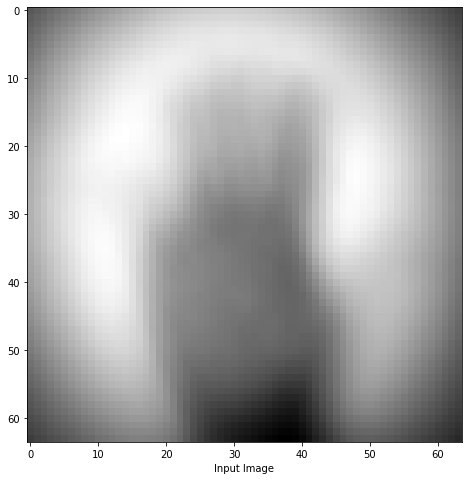

In [8]:
image_0 = image_residual
#print(smooth_img.shape)
plt.figure(1)
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('Input Image')
plt.sca(ax1)
plt.imshow(image_0, cmap='gray')
plt.show()

In [9]:
X_without_mean = [x - image_residual for x in X_unf]

In [9]:
def standardize_image(X) :
    for idx, x in enumerate(X) :
        mean = np.mean(x)
        std = np.std(x)
        X[idx] = (x - mean) / std

In [99]:
print(X.shape)
standardize_image(X_unf)

(2062, 4096)


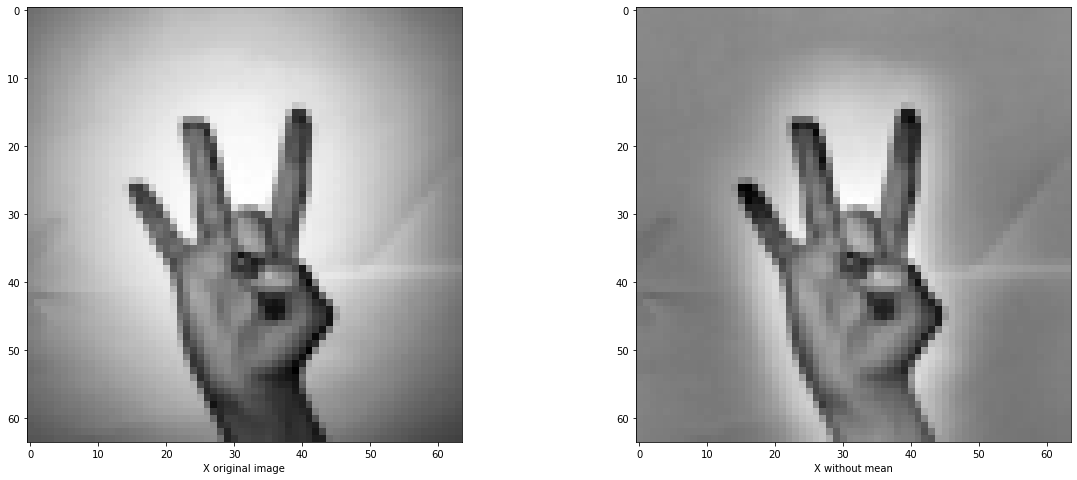

In [128]:
plt.figure(2)
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('X original image')
ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('X without mean')
plt.sca(ax1)
plt.imshow(X_unf[1200], cmap='gray', interpolation='nearest')
plt.sca(ax2)
plt.imshow(X_without_mean[1200], cmap='gray', interpolation='nearest')
plt.show()

In [10]:
X_no_mean_flattened = [x.flatten() for x in X_without_mean]

In [11]:
print(X_no_mean_flattened[0].shape)

(4096,)


In [12]:
ncomp = 64

pca2 = PCA(n_components=ncomp)  # For example 2-PC
principalComponents = pca2.fit_transform(X_no_mean_flattened[:])
    

In [13]:
principalComponents.shape

(2062, 64)

In [14]:
explained_variance = np.var(principalComponents, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
varianze=np.cumsum(explained_variance_ratio)

print(varianze)

[0.15551648 0.24727348 0.30304715 0.35665758 0.40567651 0.44934152
 0.4849728  0.51283359 0.53890313 0.56322217 0.58628632 0.60898782
 0.62922044 0.64767602 0.66570412 0.68285647 0.69914243 0.71453048
 0.72923795 0.74260061 0.75483336 0.76673033 0.77812273 0.78902134
 0.79910027 0.80839369 0.8172903  0.82581702 0.83390994 0.84152512
 0.84885909 0.85594596 0.8627736  0.86942907 0.87584325 0.88185022
 0.88784025 0.89351903 0.89916469 0.90458374 0.90992971 0.9149232
 0.91983543 0.92468186 0.92943521 0.93402078 0.93851814 0.94291184
 0.94710158 0.95118367 0.95519214 0.95913544 0.96302917 0.96677411
 0.97045419 0.97408232 0.97757857 0.98103253 0.98442394 0.98768094
 0.99089424 0.99398861 0.99704738 1.        ]


In [15]:
print(len(varianze[varianze <= 0.85] ))
print(len(varianze[varianze <= 0.95] ))

31
49


# NAIVE BAYES

## Gaussian NB

In [172]:
# working with normal images
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)

In [ ]:
model = naive_bayes_custom.NaiveBayesCustom()
model.fit(Xtrain, Ytrain)
score = cross_val_score(model, X, Y, cv=20)
Ymodel = model.predict(Xtest)

In [174]:
score.mean()

0.6265636669156086

In [187]:
mat = confusion_matrix(Ytest, Ymodel)

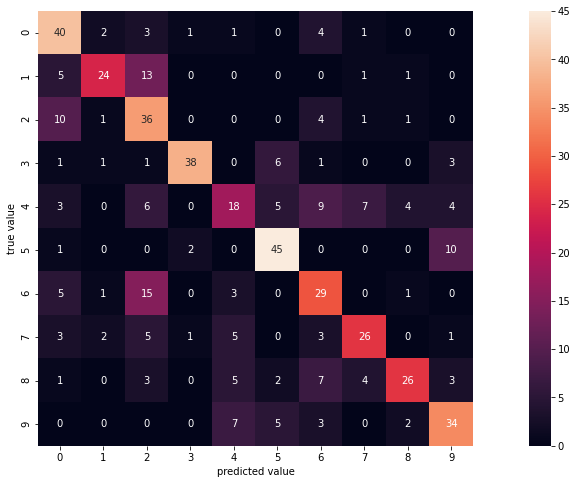

In [188]:
sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

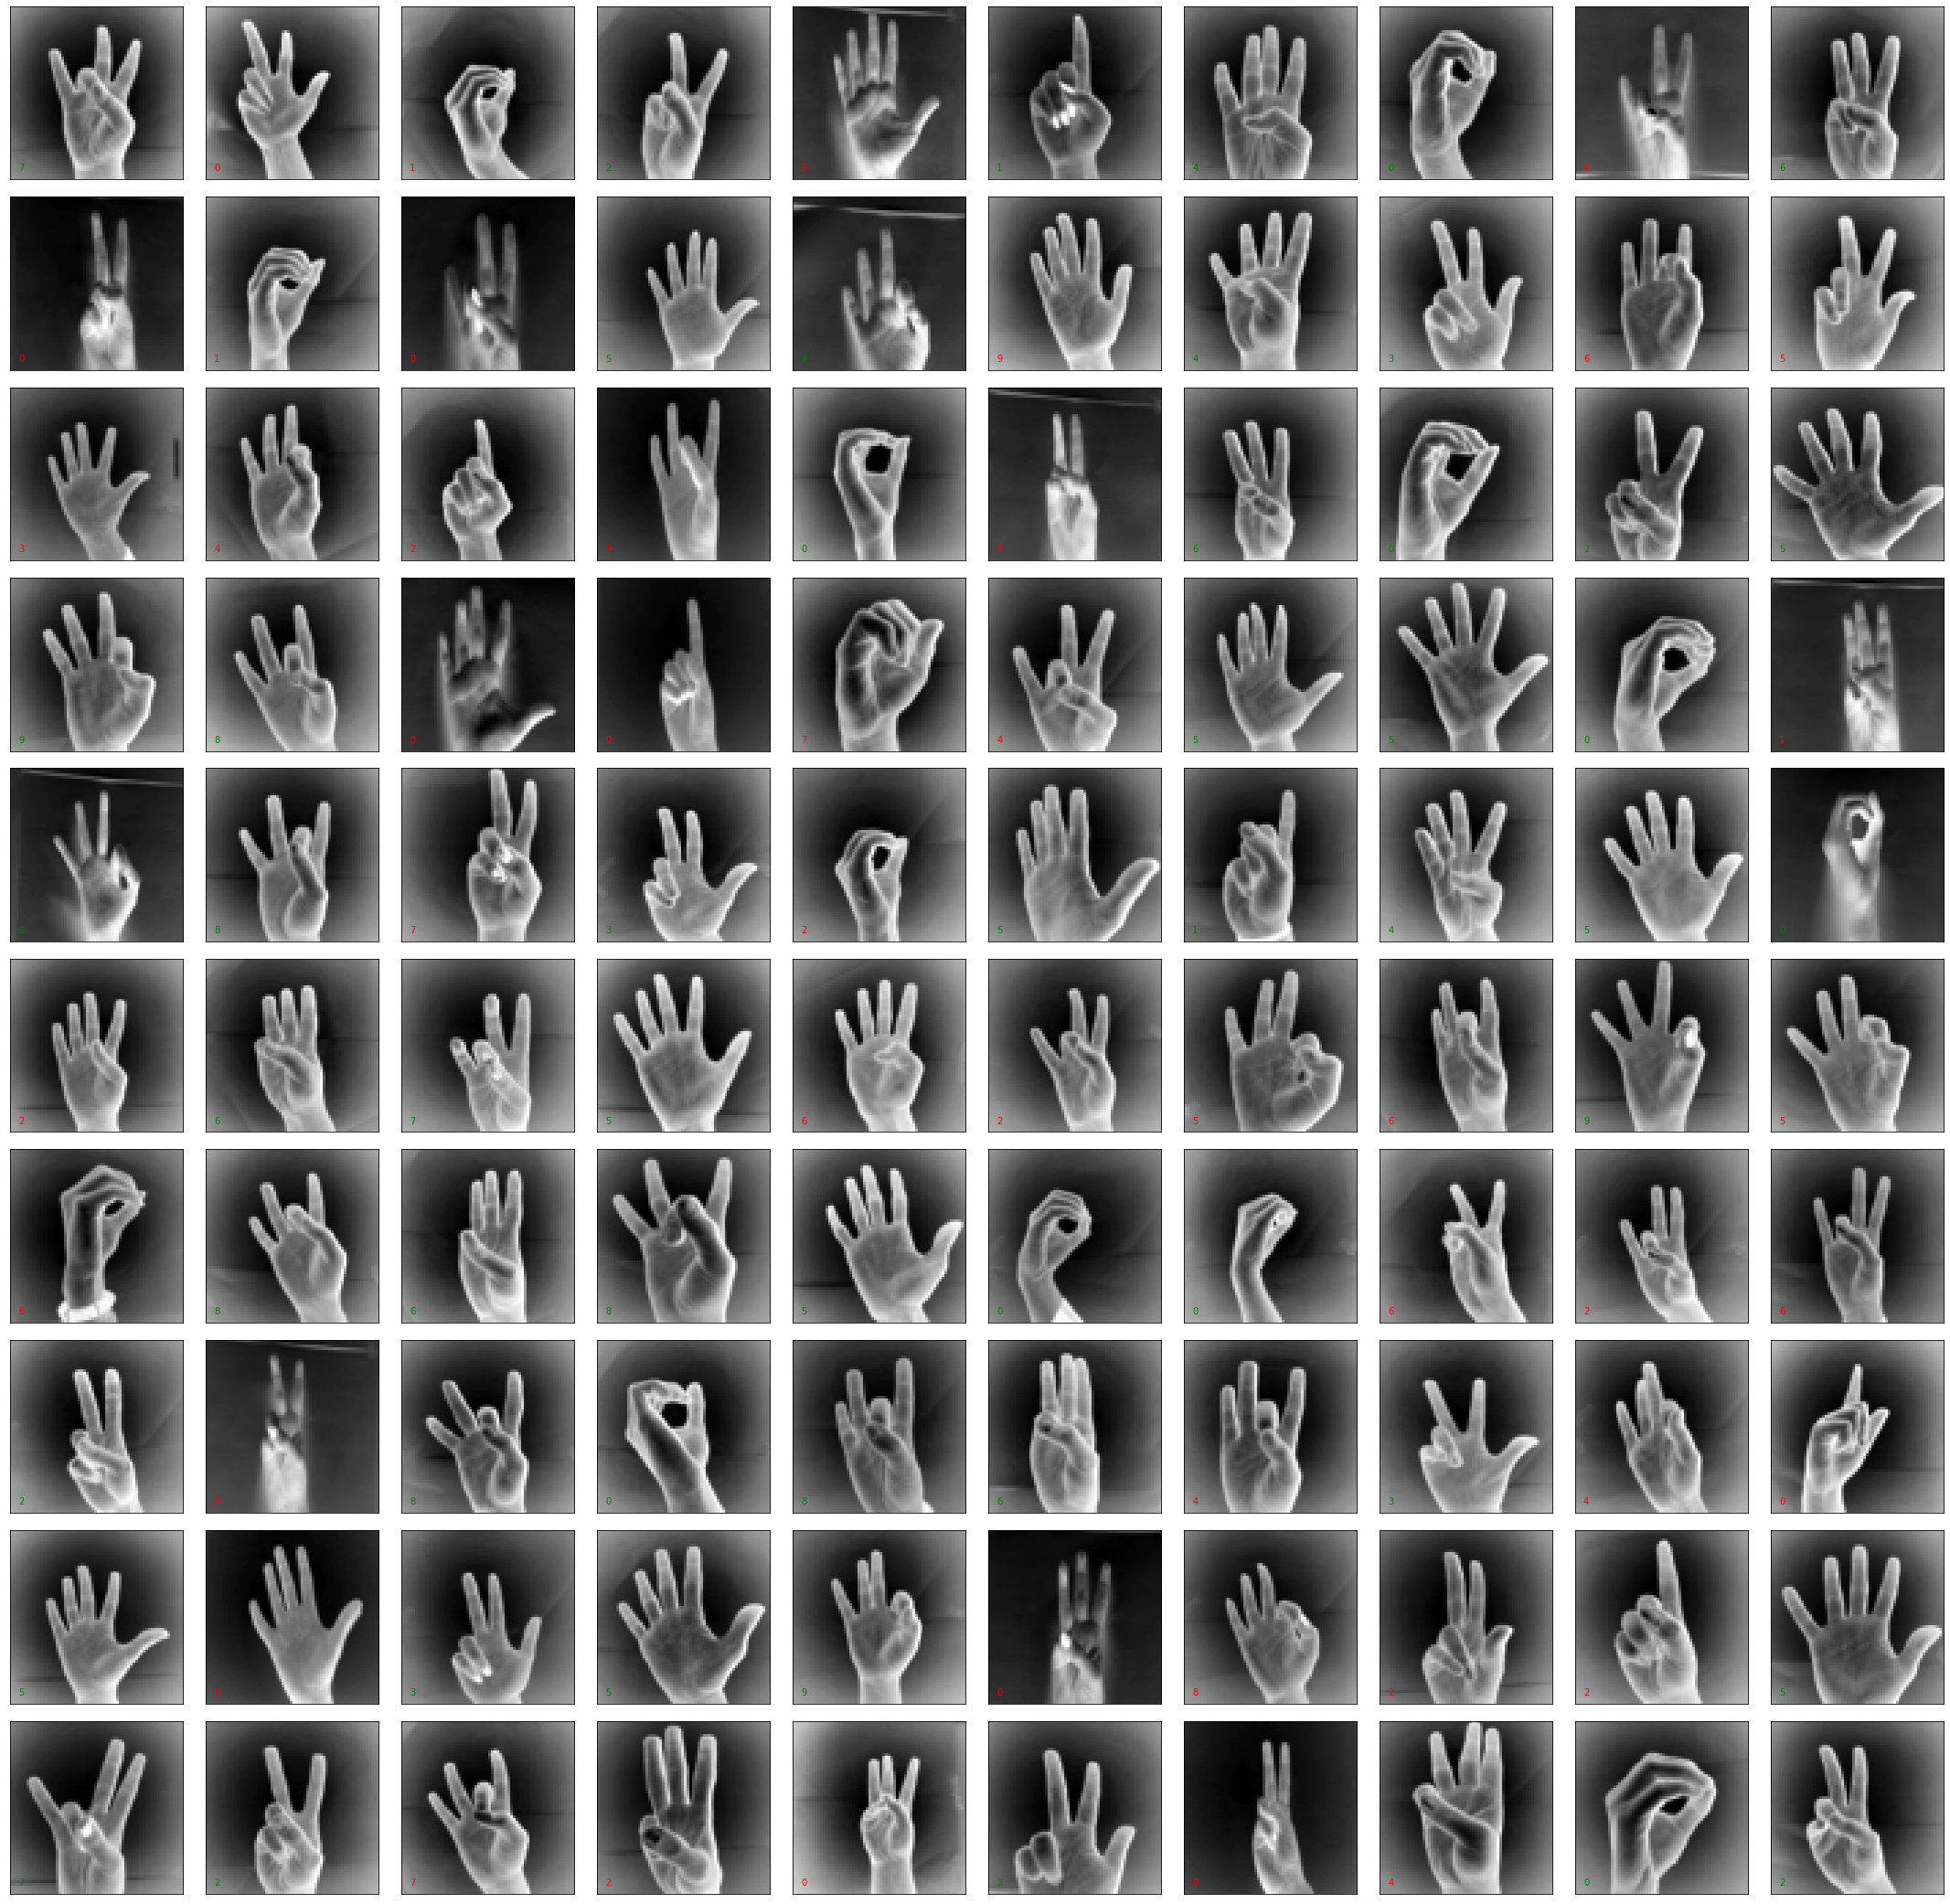

In [185]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

## GAUSSIAN NB with PCA

In [16]:
# working with normal images
XtrainPCA, XtestPCA, Ytrain, Ytest = train_test_split(principalComponents,Y)

In [49]:
model = GaussianNB()
model.fit(XtrainPCA, Ytrain)
score = cross_val_score(model, principalComponents, Y, cv=20)
Ymodel = model.predict(XtestPCA)

NameError: name 'XtrainPCA' is not defined

In [27]:
components_chances = [35, 40, 45, 50, 55, 57, 58, 59, 60]
results = []

for comp_amount in components_chances:
    PCA_matrix = principalComponents[:, :comp_amount]

    #PCA_matrix = np.array([PCA_matrix[i].flatten() for i in range(len(PCA_matrix))])
    X_train, X_test, Y_train, Y_test = train_test_split(PCA_matrix,Y)
    model = GaussianNB()
    model.fit(X_train, Y_train)
    score = cross_val_score(model, X_train, Y_train, cv=LeaveOneOut(), n_jobs = AVAILABLE_CPU)
    
    results.append(score.mean())
    

In [28]:
for i in range(len(results)):
    print(f"avg score obtained with {components_chances[i]} components : {results[i]}")

avg score obtained with 35 components : 0.7069857697283312
avg score obtained with 40 components : 0.7276843467011643
avg score obtained with 45 components : 0.7309184993531694
avg score obtained with 50 components : 0.7263906856403622
avg score obtained with 55 components : 0.7432082794307892
avg score obtained with 57 components : 0.7218628719275549
avg score obtained with 58 components : 0.7199223803363519
avg score obtained with 59 components : 0.7451487710219923
avg score obtained with 60 components : 0.7192755498059509


In [42]:
PCA_matrix = principalComponents[:, :59]
X_train, X_test, Y_train, Y_test = train_test_split(PCA_matrix,Y)
model = GaussianNB()
model.fit(X_train, Y_train)
Ymodel = model.predict(X_test)
mat = confusion_matrix(Ymodel, Y_test)
acc = accuracy_score(Y_test, Ymodel)
print(acc)

0.7054263565891473


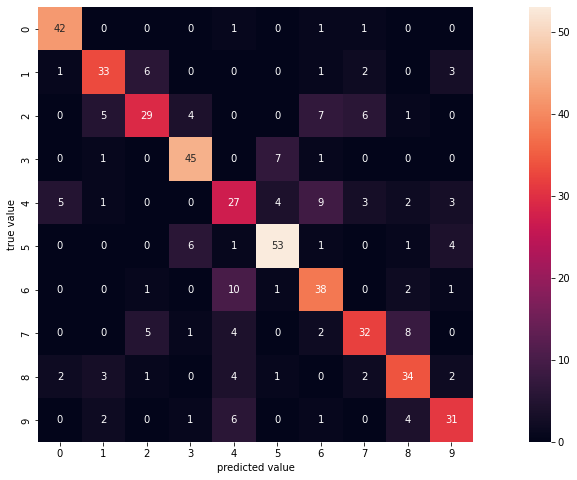

In [43]:
sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

## Multinomial NB

In [45]:
thresh = np.arange(0.45, 0.61, 0.01)
thresh

array([0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 ])

In [48]:
for threshold in tqdm(thresh):
    
    scores = []
    
    Xbw = [clean_image(X[i], threshold = threshold) for i in range(len(X))]
    Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)
    modelbw = MultinomialNB()
    modelbw.fit(Xbwtrain, Ytrain)
    
    scorebw = cross_val_score(modelbw, Xbwtrain, Ytrain, cv = 20, n_jobs = AVAILABLE_CPU)
    
    scores.append(scorebw.mean())
    
    print(f'score : {scorebw.mean()}, threshold: {threshold}')

  6%|▋         | 1/16 [00:37<09:18, 37.23s/it]

score : 0.4301698301698301, threshold: 0.45


 12%|█▎        | 2/16 [01:12<08:28, 36.29s/it]

score : 0.4364968364968364, threshold: 0.46


 19%|█▉        | 3/16 [01:47<07:40, 35.39s/it]

score : 0.45197302697302694, threshold: 0.47000000000000003


 25%|██▌       | 4/16 [02:21<07:01, 35.13s/it]

score : 0.4768564768564768, threshold: 0.48000000000000004


 31%|███▏      | 5/16 [02:57<06:28, 35.36s/it]

score : 0.4573176823176823, threshold: 0.49000000000000005


 38%|███▊      | 6/16 [03:32<05:50, 35.09s/it]

score : 0.47549117549117553, threshold: 0.5


 44%|████▍     | 7/16 [04:08<05:19, 35.52s/it]

score : 0.46886446886446886, threshold: 0.51


 50%|█████     | 8/16 [04:46<04:51, 36.38s/it]

score : 0.4798534798534799, threshold: 0.52


 56%|█████▋    | 9/16 [05:23<04:16, 36.59s/it]

score : 0.488927738927739, threshold: 0.53


 62%|██████▎   | 10/16 [06:02<03:43, 37.21s/it]

score : 0.48439893439893433, threshold: 0.54


 69%|██████▉   | 11/16 [06:40<03:07, 37.44s/it]

score : 0.5025058275058275, threshold: 0.55


 75%|███████▌  | 12/16 [07:19<02:31, 37.92s/it]

score : 0.4663003663003663, threshold: 0.56


 81%|████████▏ | 13/16 [07:56<01:52, 37.51s/it]

score : 0.4948801198801197, threshold: 0.5700000000000001


 88%|████████▊ | 14/16 [08:33<01:15, 37.58s/it]

score : 0.49351481851481854, threshold: 0.5800000000000001


 94%|█████████▍| 15/16 [09:11<00:37, 37.71s/it]

score : 0.4813686313686313, threshold: 0.5900000000000001


100%|██████████| 16/16 [09:49<00:00, 36.84s/it]

score : 0.502056277056277, threshold: 0.6000000000000001


In [ ]:
for threshold in [0.55, 0.60]:
    
    scores = []
    
    Xbw = [clean_image(X[i], threshold = threshold) for i in range(len(X))]
    Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)
    modelbw = MultinomialNB()
    modelbw.fit(Xbwtrain, Ytrain)
    
    scorebw = cross_val_score(modelbw, Xbwtrain, Ytrain, cv = LeaveOneOut(), n_jobs = AVAILABLE_CPU)
    
    scores.append(scorebw.mean())
    
    print(f'score : {scorebw.mean()}, threshold: {threshold}')

In [215]:
Xbw = [clean_image(X[i], threshold = 0.57) for i in range(len(X))]

Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)
modelbw = MultinomialNB()
modelbw.fit(Xbwtrain, Ytrain)

Ymodelbw = modelbw.predict(Xbwtest)

mat = confusion_matrix(Ytest, Ymodelbw)

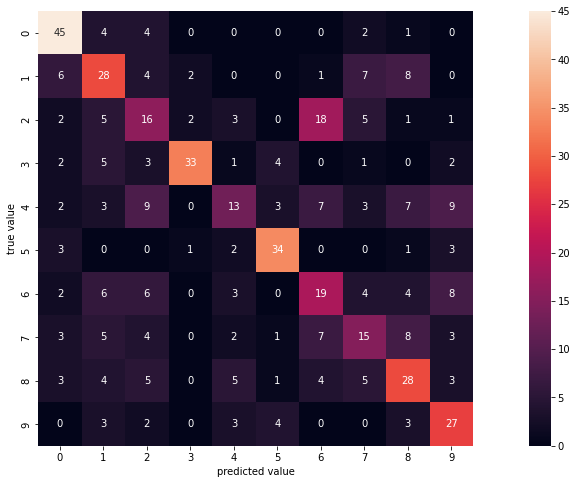

In [ ]:
sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

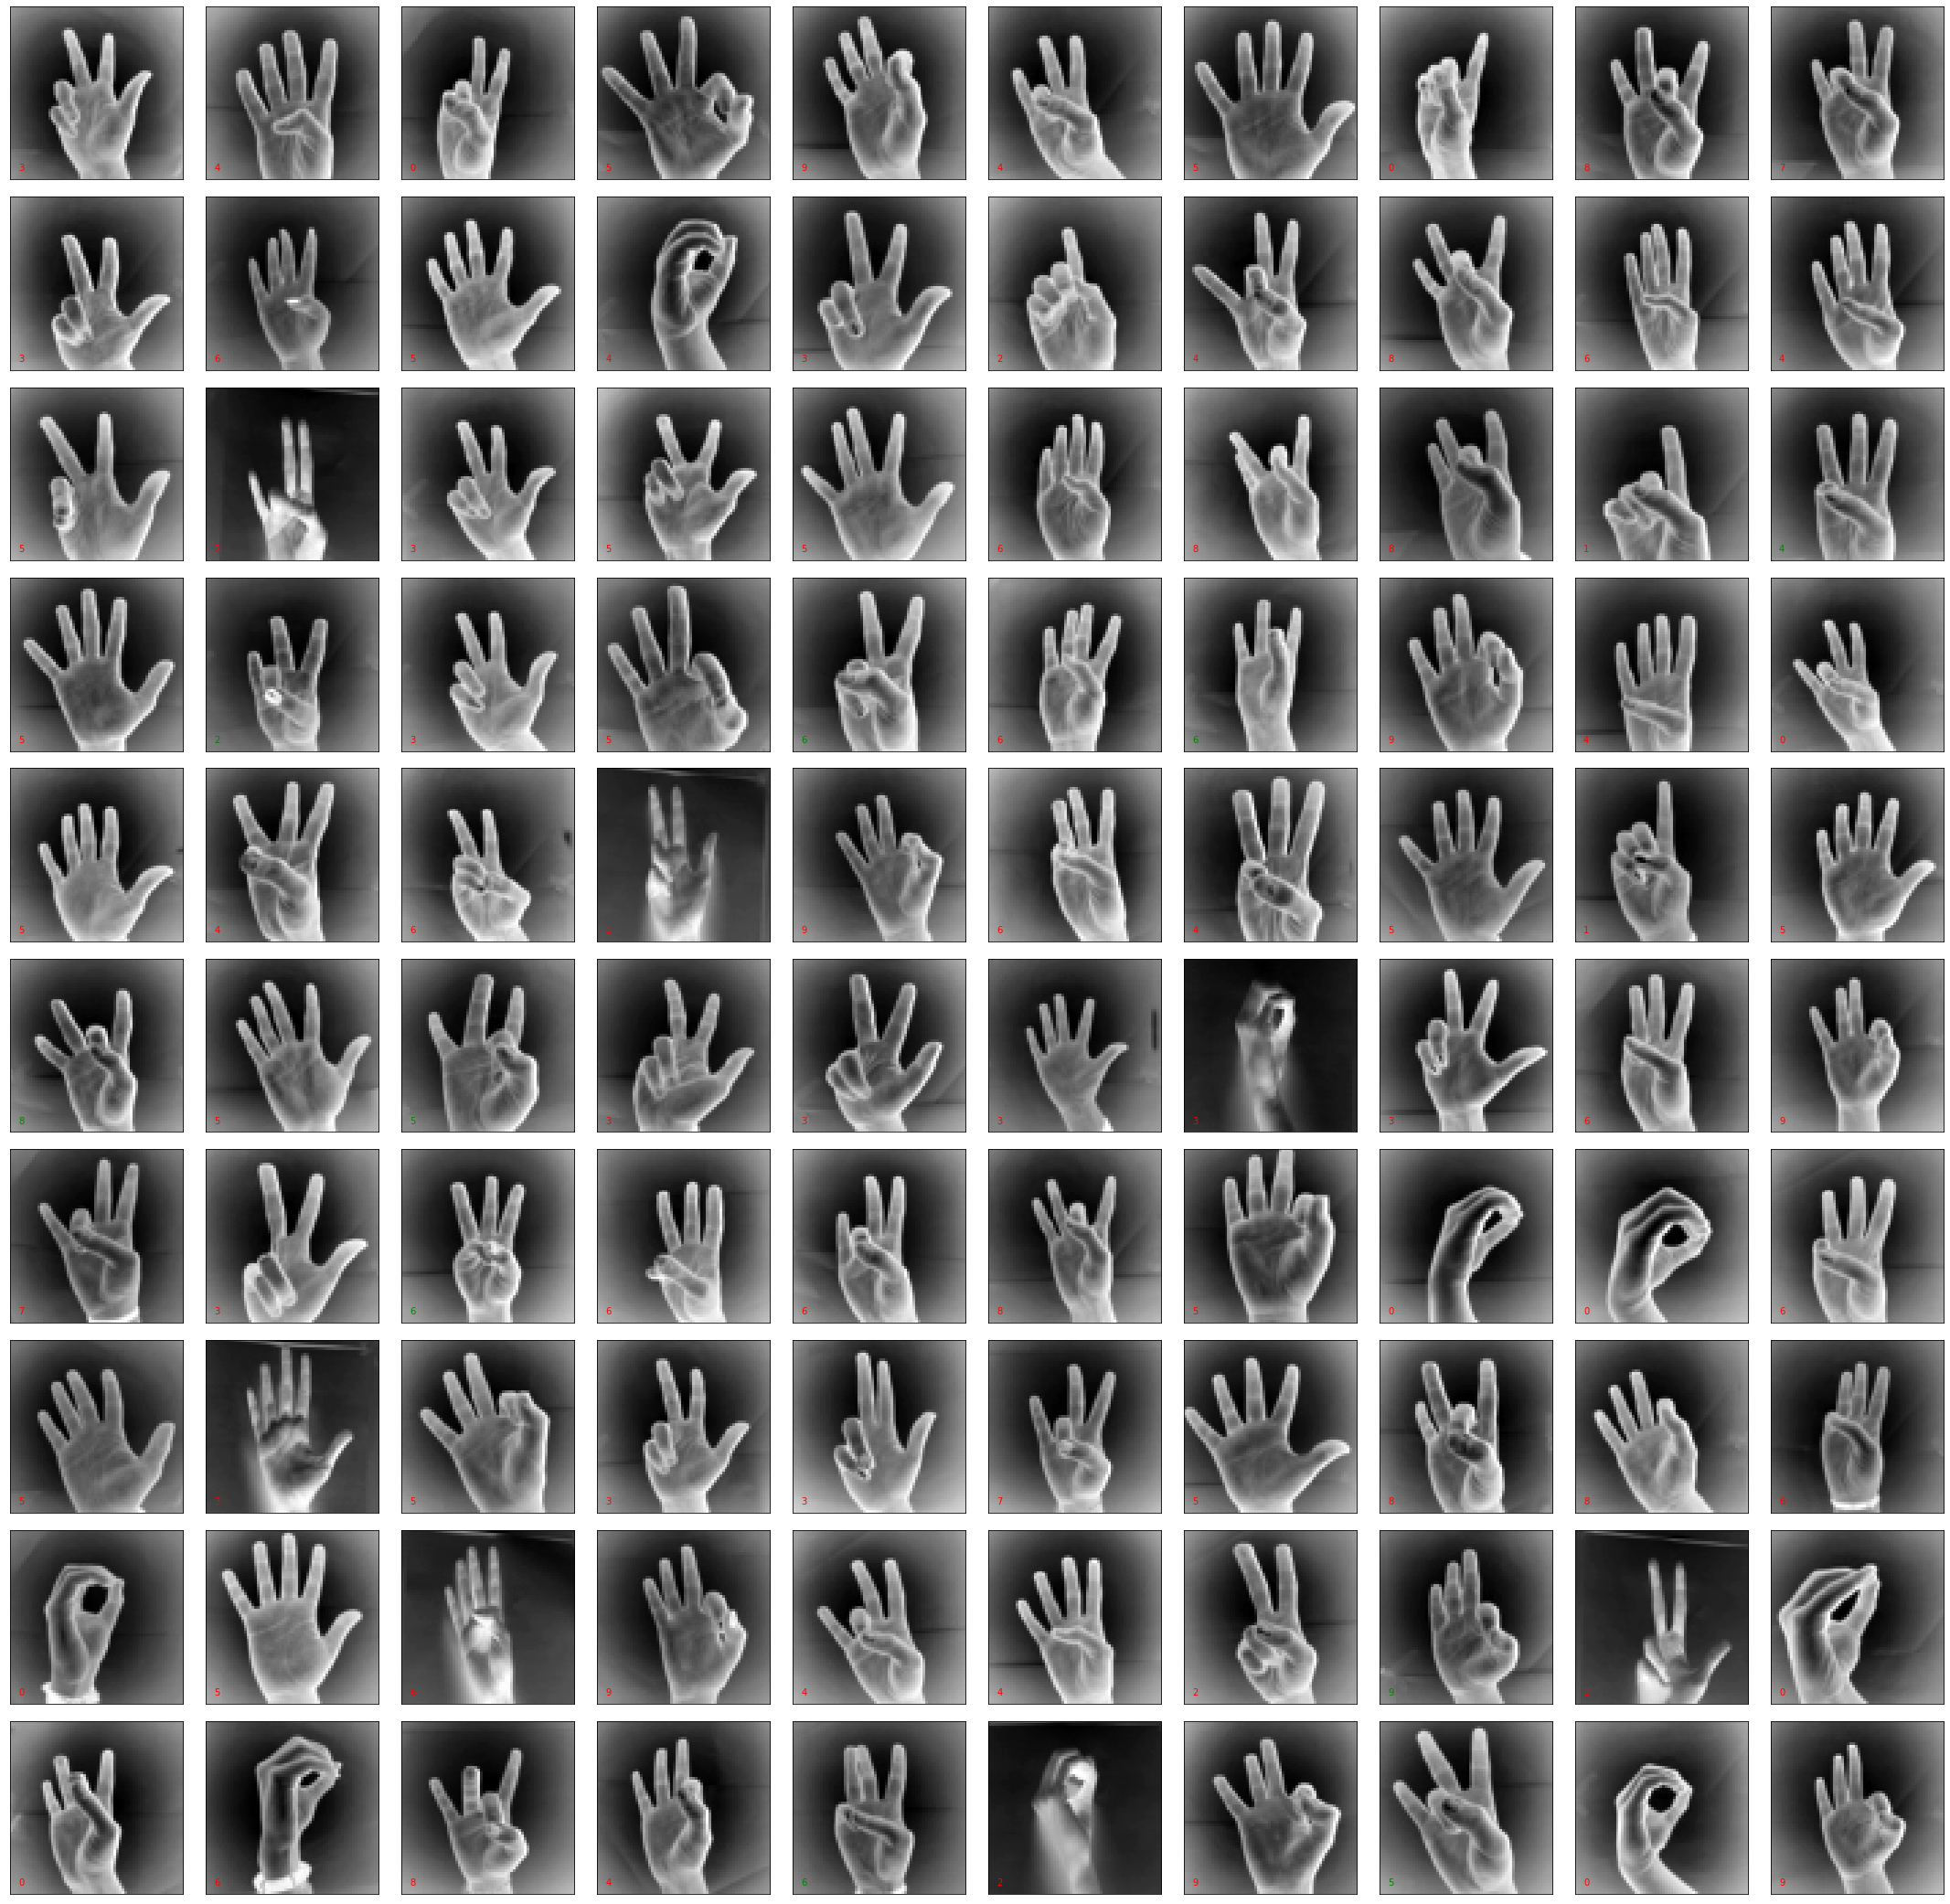

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

## Custom Gaussian for error understanding

In [ ]:
# working with normal images
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)

In [ ]:
model = naive_bayes_custom.NaiveBayesCustom()
model.fit(Xtrain, Ytrain)
score = cross_val_score(model, X, Y, cv=20)
Ymodel = model.predict(Xtest)

In [ ]:
img_indexes = np.where(Y == 6)[0]
for img_index in img_indexes :
    #plt.imshow(X[img_index].reshape(64, 64), cmap='gray', interpolation='nearest')
    likes = (model.custom_predict([X[img_index]]))
    top_l = model.classes_[likes[0].argmax()]
    if(top_l != 6):
        print(f"Top likelihood is: {top_l} for index {img_index}")

Top likelihood is: 2 for index 615
Top likelihood is: 8 for index 616
Top likelihood is: 2 for index 617
Top likelihood is: 4 for index 619
Top likelihood is: 2 for index 623
Top likelihood is: 0 for index 626
Top likelihood is: 7 for index 632
Top likelihood is: 2 for index 633
Top likelihood is: 2 for index 635
Top likelihood is: 0 for index 636
Top likelihood is: 4 for index 637
Top likelihood is: 0 for index 638
Top likelihood is: 2 for index 639
Top likelihood is: 0 for index 640
Top likelihood is: 7 for index 641
Top likelihood is: 2 for index 645
Top likelihood is: 0 for index 648
Top likelihood is: 7 for index 650
Top likelihood is: 2 for index 653
Top likelihood is: 2 for index 654
Top likelihood is: 2 for index 655
Top likelihood is: 2 for index 660
Top likelihood is: 9 for index 661
Top likelihood is: 4 for index 664
Top likelihood is: 0 for index 667
Top likelihood is: 2 for index 668
Top likelihood is: 1 for index 670
Top likelihood is: 0 for index 676
Top likelihood is: 2

Top likelihood is: 3 for index 813
Likelihood for class 0 : 2431.7856949387738
Likelihood for class 1 : -3084.7961703096375
Likelihood for class 2 : 1167.730139497847
Likelihood for class 3 : 3234.8730231760055
Likelihood for class 4 : 3083.5097357761347
Likelihood for class 5 : 2686.782396149008
Likelihood for class 6 : 3088.3443102074616
Likelihood for class 7 : 2182.5105516268814
Likelihood for class 8 : 2682.557167979319
Likelihood for class 9 : 2727.0063644622705


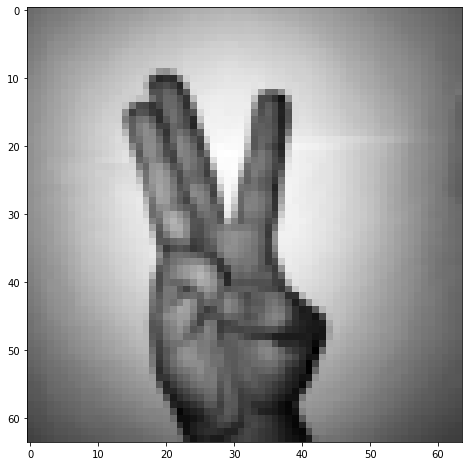

In [ ]:
# cose notate : 
# 636 c'é lo smalto  -- color filling
# 617 é inclinato    -- color filling
# 653 é inclinato
# 813 le dita sono attaccate -- edge recognition

img_index = 813
plt.imshow(X[img_index].reshape(64, 64), cmap='gray', interpolation='nearest')
likes = (model.custom_predict([X[img_index]]))
top_l = model.classes_[likes[0].argmax()]
if(top_l != 6):
    print(f"Top likelihood is: {top_l} for index {img_index}")
for i in range(len(model.classes_)) :
    class_l = likes[0][0][i]
    print(f"Likelihood for class {model.classes_[i]} : {class_l}")


## Multinomial NB with edge detection

In [7]:
def convert_png_to_array(img):
    '''
    Input:
        img <- a path to a .png image
    Output:
        array_img <- a numpy matrix (64, 64)
    '''
    
    png = Image.open(img)
    array_img = np.asarray(png)

    return array_img

In [4]:
X_e = [] 
for i in range(len(X_unf)):
    
    path = f'./png/train{i}.png'
    X_e.append(convert_png_to_array(path))

X_e = np.array([X_e[i].flatten() for i in range(len(X_e))])

In [5]:
# working with normal images
X_e_train, X_e_test, Ytrain, Ytest = train_test_split(X_e,Y)

In [6]:
model = MultinomialNB()
model.fit(X_e_train, Ytrain)
score = cross_val_score(model, X_e_train, Ytrain, cv=20)
Ymodel = model.predict(X_e_test)
score.mean()

0.6533466533466533

In [7]:
mat = confusion_matrix(Ytest, Ymodel)
acc = accuracy_score(Ytest, Ymodel)
acc

0.6531007751937985

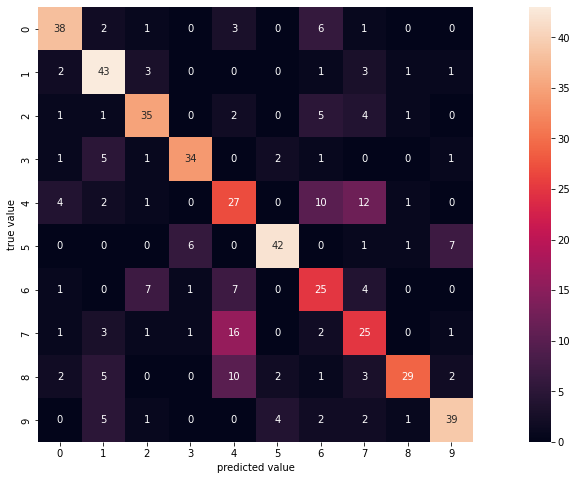

In [10]:
# OSS: 
#      - predict <- 7, true <- 4 
#      - predict <- 4, true <- 8, 7
#      - predict <- 5, true <- 9

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

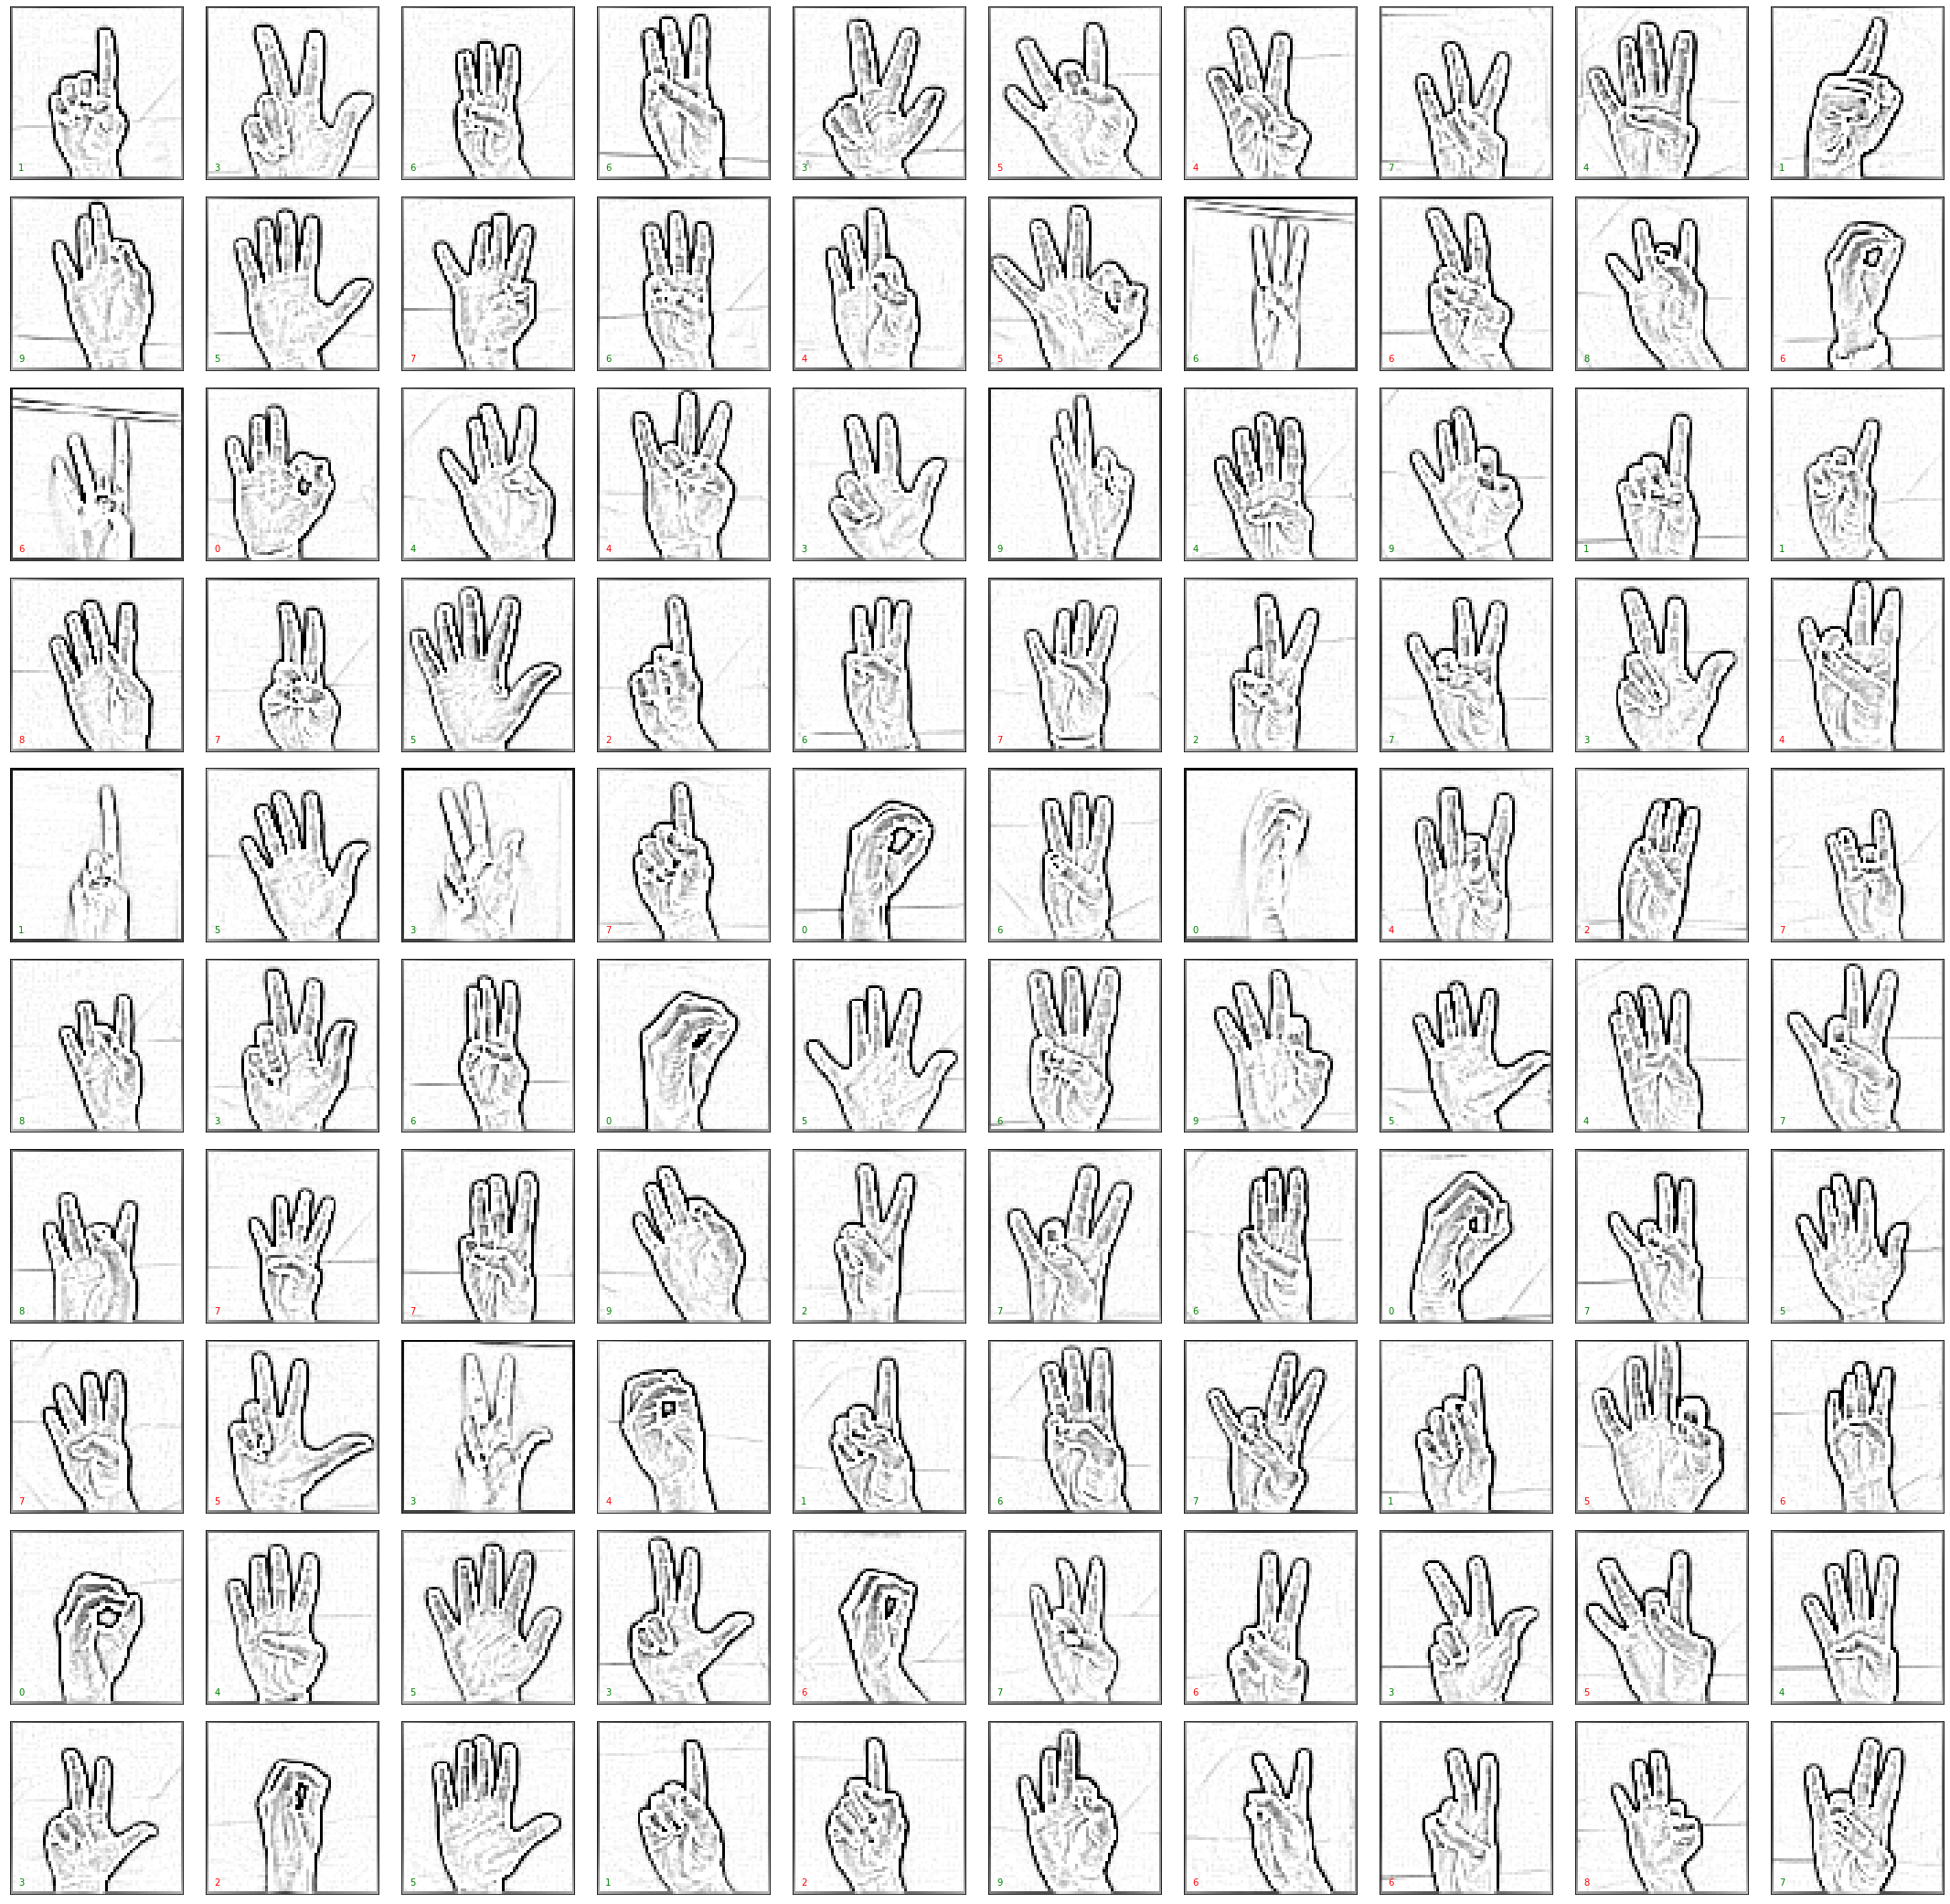

In [48]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = X_e_test.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

# Edge detection and Chamfer distance

Transforming the numpy arrays in png images to apply the edge detection

In [12]:
for i in range(len(X_unf)):
    
    # given images in range [0,1] we have to normalize them using Min-Max and rescaling them to RGB
    I = cv2.normalize(X_unf[i], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) 
    name = f'./png/train{i}.png'
    imsave(name, I)
    image = Image.open(name)
    
    # reconvert to grayscale
    image = image.convert("L")
    
    # Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
    image = image.filter(ImageFilter.FIND_EDGES)
    
    # Saving the Image Under the name test{i}.png
    image.save(name)

## Chamfer distance

Reconverting the edge detected png's to numpy arrays to compute the Chamfer distance

In [208]:
def chamfer_distance(x, y, metric='l2', direction='x_to_y'):
    """Chamfer distance between two point clouds
    Parameters
    ----------
    x: numpy array [n_points_x, n_dims]
    y: numpy array [n_points_y, n_dims]
    
    metric: metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.
            OSS: the used direction of Chamfer distance is 'x_to_y' --->  computes average minimal distance from every point in x to y

    Returns
    -------
    chamfer_dist: float
    """
   
    if direction == 'x_to_y':
        
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]

        chamfer_dist = np.mean(min_x_to_y)
    
    elif direction=='bi':
        
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        
        chamfer_dist = np.mean(min_y_to_x) + np.mean(min_x_to_y)

        
    return chamfer_dist

Computing chamfer distance of a '9' and all the other test images, the distance with the correct match is the lowest

In [80]:
def testSet_chamfer(X, k):
    
    '''
    This function creates a random test set for the chamfer distance computation
    Input:
        - X: the matrix with the numpy images flattened
        - k: number of images to pick at random from each class
    Output:
        - A matrix of k images for each class
    '''
    
    n_classes = 10
    flattened_image_length = 4096
    X_test = np.empty((0))
    
    lower = [0, 204, 409, 615, 822, 1028, 1236, 1443, 1649, 1855]
    upper = [203, 408, 614, 821, 1027, 1235, 1442, 1648, 1854, 2061]
    
    for i in range(len(lower)):
        class_digit = X[lower[i]:upper[i]]
        sample = class_digit[np.random.choice(class_digit.shape[0], k, replace=False)]
        for image in sample:
            X_test = np.append(X_test, image)
            
    return X_test.reshape(k*n_classes, flattened_image_length)


In [213]:
k = 1
Chamfer_test = testSet_chamfer(X_e, k)

In [214]:
digits = [9, 0, 7, 6, 1, 8, 4, 3, 2, 5]

score_trim = 0
score_mean = 0
score_median = 0
score_min = 0

for m in range(100):
    
    tot_scores = []
    digit_score_trim = []
    digit_score_mean = []
    digit_score_median = []
    
    idx = np.random.choice(X_e.shape[0])
    test = X_e[idx].reshape(64, 64)

    for i in range(len(digits)):
        score = []
        class_k = Chamfer_test[(i*k):(i*k)+4]

        for el in class_k:
            score.append(chamfer_distance(test, el.reshape(64, 64)))
            tot_scores.append((chamfer_distance(test, el.reshape(64, 64)), i))
            
        digit_score_trim.append(stats.trim_mean(score, 0.1))
        digit_score_mean.append(np.mean(score))
        digit_score_median.append(median(score))

    best_min = min(tot_scores)    
    best_trim = min(digit_score_trim)
    best_mean = min(digit_score_mean)
    best_median = min(digit_score_median)
    
    best_min_class = best_min[1]
    best_trim_class = digits[np.where(digit_score_trim == best_trim)[0][0]]
    best_mean_class = digits[np.where(digit_score_mean == best_mean)[0][0]]
    best_median_class = digits[np.where(digit_score_median == best_median)[0][0]]
    
    ground = Y[idx]
    
    if best_trim_class == ground: score_trim += 1
    if best_mean_class == ground: score_mean += 1
    if best_median_class == ground: score_median += 1
    if best_min_class == ground: score_min += 1
    
print(f'trimmed mean score {score_trim/100}')
print(f'mean score {score_mean/100}')
print(f'median score {score_median/100}')
print(f'min score {score_min/100}')

trimmed mean score 0.12
mean score 0.12
median score 0.12
min score 0.07


### Extract likelihoods for every label

In [30]:
labels_likelihoods = compute_likelihood_mt(Y_hot_vec,X_unf)

#### Plot residual images

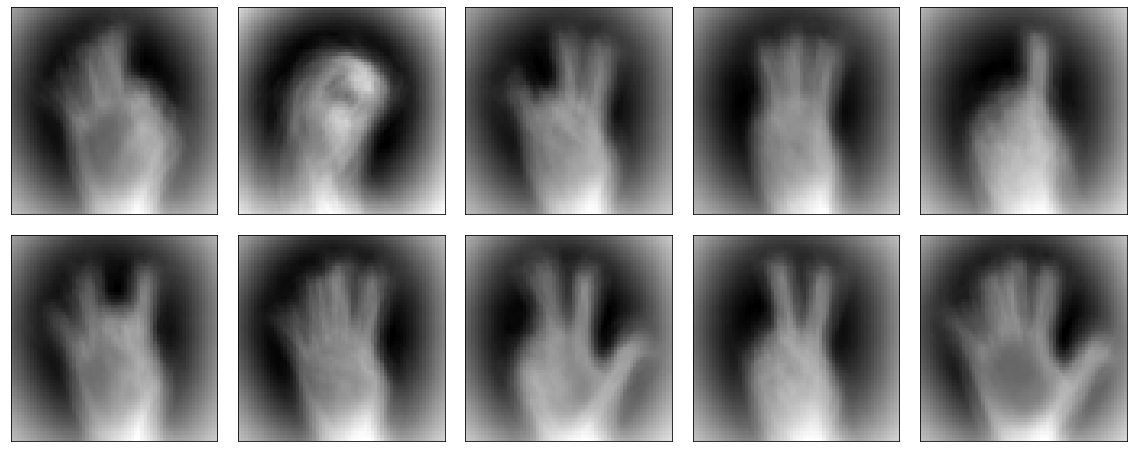

In [44]:
fig, axes = plt.subplots(2, 5, 
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(labels_likelihoods[i], cmap='binary', interpolation='nearest')

#### Save residual images to png

In [50]:
likelihoods = list(labels_likelihoods.values())
for i in range(len(likelihoods)):
    
    # given images in range [0,1] we have to normalize them using Min-Max and rescaling them to RGB
    I = cv2.normalize(likelihoods[i], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) 
    name = f'./likelihoods_png/label_{i}.png'
    imsave(name, I)
    image = Image.open(name)
    
    # reconvert to grayscale
    image = image.convert("L")
    
    # Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
    image = image.filter(ImageFilter.FIND_EDGES)
    
    # Saving the Image Under the name test{i}.png
    image.save(name)